In [12]:
import pandas as pd
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
nltk.data.path.append('/home/sujay1844/.local/share/nltk_data/')
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Load the pre-trained BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('google/bert_uncased_L-2_H-128_A-2', from_pt=True)
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2', from_pt=True)
# Load the model
model = tf.keras.models.load_model('./bert-tiny-1k.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [14]:
max_length = 100
embedding_size = 128

import time
def vectorize_and_preprocess(sentence):

    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    input_ids = tf.convert_to_tensor([input_ids])

    embeddings = bert_model(input_ids)[0][0].numpy()

    padded_embeddings = pad_sequences(
        [embeddings],
        maxlen=max_length,
        padding='post',
        truncating='post'
    )
    cnn_input = padded_embeddings.reshape((max_length, embedding_size, 1))
    return cnn_input
# _ = vectorize_and_preprocess("The quick brown fox jumps over the lazy dog.")

In [15]:
def find_similarity(sent1, sent2):
	vector1 = vectorize_and_preprocess(sent1)
	vector2 = vectorize_and_preprocess(sent2)

	vector1 = vector1.reshape((1, max_length, embedding_size, 1))
	vector2 = vector2.reshape((1, max_length, embedding_size, 1))

	return model.predict([vector1, vector2], verbose=False)

In [16]:
def find_similarity_matrix(sents1, sents2):
	similarity_matrix = np.zeros((len(sents1), len(sents2)))

	for i in range(len(sents1)):
		for j in range(len(sents2)):
			similarity_matrix[i][j] = find_similarity(sents1[i], sents2[j])
	return similarity_matrix

In [17]:
# display similarity matrix as a heatmap
def display_heatmap(similarity_matrix):
	sns.heatmap(similarity_matrix, cmap='RdYlGn_r', vmin=0, vmax=1)
	plt.show()

In [18]:
import time
def get_similarity(essay1, essay2, display=False):
	sents1 = sent_tokenize(essay1)
	sents2 = sent_tokenize(essay2)

	start = time.perf_counter()

	similarity_matrix = find_similarity_matrix(sents1, sents2)

	end = time.perf_counter()
	total_time = end - start
	avg_time = total_time / (len(sents1) * len(sents2))

	if display:
		display_heatmap(similarity_matrix)

	return {
		'similarity_score': similarity_matrix.max(axis=0).mean(),
		'total_time': total_time,
		'avg_time': avg_time,
		# 'similarity_matrix': similarity_matrix,
		'essay1': {
			'sentences': len(sents1),
			'words': len(word_tokenize(essay1)),
		},
		'essay2': {
			'sentences': len(sents2),
			'words': len(word_tokenize(essay2)),
		}
		
	}

In [19]:
essay1 = "The Positive Impact of Social Media on the Younger Generation.  Social media has become an integral part of the younger generation's life. It has made communication more accessible and easier than ever before. The younger generation has grown up in a digital world, and social media has become a way of life for them. There are many positive impacts of social media on the younger generation.  One of the significant benefits of social media is that it has brought people closer. It has created a platform where people from different parts of the world can connect and interact. The younger generation has used social media to build relationships and make friends with people they might not have met otherwise.  Social media has also played a crucial role in raising awareness about social issues. The younger generation has used social media to educate themselves about various social issues, and they have used their platforms to raise awareness about issues such as climate change, social justice, and mental health.  Moreover, social media has provided a platform for the younger generation to showcase their talents and skills. Many young people have used social media to launch their careers and gain recognition for their talents.  In conclusion, social media has had a positive impact on the younger generation. It has provided a platform for communication, raised awareness about social issues, and enabled young people to showcase their talents and skills. While there are concerns about the negative impact of social media, it is essential to recognize the positive impact it has had on the younger generation."
essay2 = "The Negative Impact of Social Media on the Younger Generation.  Social media has become an integral part of the younger generation's life. It has transformed the way people communicate and interact with each other. While there are many benefits of social media, it has also had a negative impact on the younger generation.  One of the significant negative impacts of social media is its impact on mental health. Social media has been linked to increased levels of anxiety, depression, and loneliness among young people. Young people are constantly exposed to images of perfection and success on social media, which can create unrealistic expectations and cause them to feel inadequate.  Social media has also created a culture of comparison among the younger generation. Young people are constantly comparing themselves to others on social media, which can lead to feelings of envy and dissatisfaction. This can lead to low self-esteem and a negative body image.  Another negative impact of social media is its impact on relationships. Social media has made it easier for people to connect, but it has also made it easier for people to disconnect. The younger generation has become more reliant on social media to communicate with others, which can lead to a lack of face-to-face communication and real connections.  In conclusion, social media has had a negative impact on the younger generation. It has been linked to mental health problems, created a culture of comparison, and affected relationships. While social media has many benefits, it is essential to recognize its negative impact and take steps to minimize its negative effects on the younger generation."

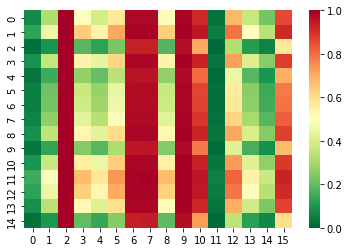

0.6840739937033504

In [20]:
res = get_similarity(essay1, essay2, display=True)
res['similarity_score']

| Bert | without GPU | with GPU | Similarity score |
|----|----|---|---|
| Base | 650ms | 90ms | 0.387 |
| Tiny | 230ms | 30ms | 0.684 |




In [22]:
res['avg_time']

0.23528089810000286